# <center> MDI341 - Alexandre Durand - 2017/2018
# <center> Challenge : Image Classification

# Introduction

###  Challenge MDI341 2018
#### Authors :  Umut Şimşekli 


The goal of this challenge is to develop a binary classification system which tries to detect if an **image contains moustache or not**.    

As opposed to the previous challenge, we will follow a different procedure in this challenge. The challenge will have **two phases**. Please read the below information carefully.  

**In the first phase** of the challenge, you will be provided a **training dataset** which contains the **raw images** and their corresponding **labels**. We will also provide you a **validation dataset**, which only contains the **raw images**. The labes of the validation set will not be provided. In this phase, you will train your system based on this data and the ranking in the challenge webpage will be based on your score obtained on the validation data.

**The second phase** of the challenge will start only **a couple of hours before the deadline**. Within this period, we will provide you the **test set**. You will need to run the algorithm that you developed on the first phase on this dataset and submit your predictions to the challenge webpage. Your **final ranks** will be determined on this dataset. Note that **this phase will only last a couple of hours**, which means that you will not be able to tune your algorithm on this dataset.



## The properties of the dataset:

**Training data:**

The training set contains raw images and their labels. There are 111430 images in this dataset. Each image is of size 56 x 56 x 3 (the last dimension encodes the color information: red-green-blue). For each image there is a label, either 0 or 1. 0 means there is no moustache in the image, 1 means otherwise.

**Validation data:**

The validation set only contains raw images. There are 10130 images in this dataset, where the image format is the same as before. The labels of this dataset will not be provided. Within the first phase, your ranks will be calculated based on this dataset. 


**Test data:**

The test set only contains raw images as well. There will be 81039 images in this dataset, where the image format is the same as before. The labels of this dataset will not be provided either. This dataset will be provided only in the second phase: only a couple of hours before the challenge deadline. Your final ranks will be calculated based on this dataset. 



### The performance criterion

As you will observe after examining the dataset, the data is highly unbalanced. Therefore, we choose a suitable criterion for evaluation: the performance criterion will be the average accuracy for each class, which is computed as follows: 


$\text{score} = \frac1{2} \Biggl( \frac1{N_0}\sum_{i=1}^{N} (1-y_i)(1-\hat{y}_i) + \frac1{N_1}\sum_{i=1}^{N} y_i \hat{y}_i \Biggr),$

where $N$ denotes the total number elements of the dataset (it could be the training, validation or test set), $N_0$ denotes the number of elements whose labels are $0$, $N_1$ similarly denotes the number of elements whose labels are $1$, $y_i$ denotes the true label of the data sample $i$, and $\hat{y}_i$ denotes the predicted label for the data sample $i$. 


As an example, if all your predictions are 0, then your score will be 50%. The higher the score, the better the performance.



# Training Data

Images: https://XXXXXXXXXX/db_train.raw

Labels: https://XXXXXXXXXX/label_train.txt


# Validation Data

Images: https://XXXXXXXXXX/db_val.raw


In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import train_test_split

import Layers

from time import time

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set()

# Part 1 : Loading & Preprocessing

## 1.1 Loading and investigating the data

In [2]:
train_images_fname = '../data/db_train.raw'
train_labels_fname = '../data/label_train.txt'

val_images_fname    = '../data/db_val.raw'

test_images_fname    = '../data/db_test.raw'


# number of images
num_train_images = 111430
num_valid_images = 10130
num_test_images = 81039


# size of the images 56*56 pixels in RGB
image_dim = 56 * 56 * 3

train_images_label = np.loadtxt(train_labels_fname, dtype=np.float64)

with open(train_images_fname, 'rb') as f:
    train_images_data = np.fromfile(f, dtype=np.uint8, count=num_train_images * image_dim).astype(np.float32)
    train_images_data = train_images_data.reshape(num_train_images, image_dim)
    
with open(val_images_fname, 'rb') as f:
    val_images_data = np.fromfile(f, dtype=np.uint8, count=num_valid_images * image_dim).astype(np.float32)
    val_images_data = val_images_data.reshape(num_valid_images, image_dim)

with open(test_images_fname, 'rb') as f:
    test_images_data = np.fromfile(f, dtype=np.uint8, count=num_test_images * image_dim).astype(np.float32)
    test_images_data = test_images_data.reshape(num_test_images, image_dim)


In [3]:
# Investigation
print("train data :", train_images_data.shape)
print("train label :", train_images_label.shape)
print("validation data :", val_images_data.shape)
print("test data :", test_images_data.shape)

train data : (111430, 9408)
train label : (111430,)
validation data : (10130, 9408)
test data : (81039, 9408)


Let's look at some images for each label:

 ==> For label : 0


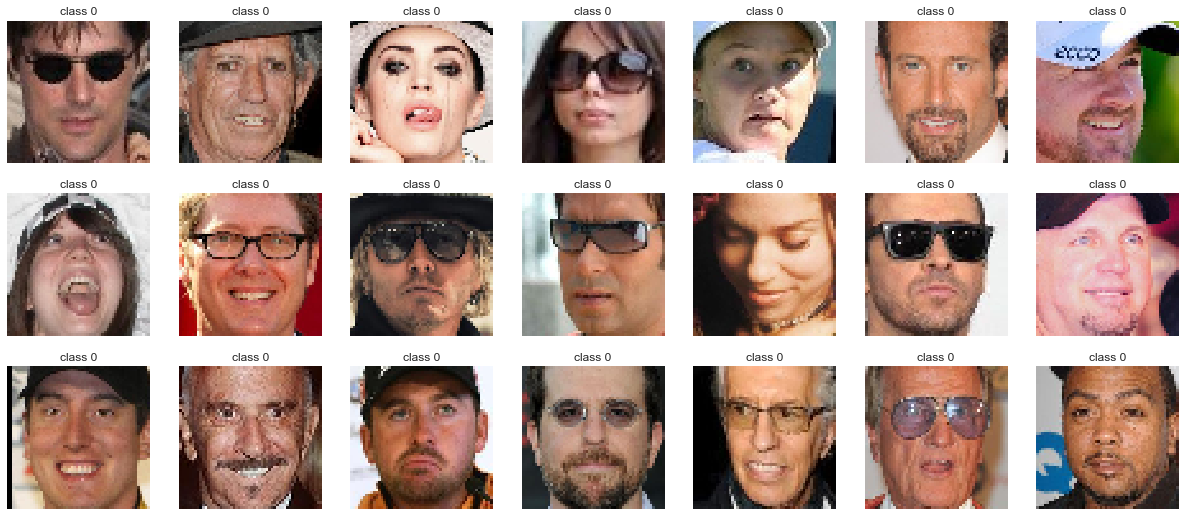

 ==> For label : 1


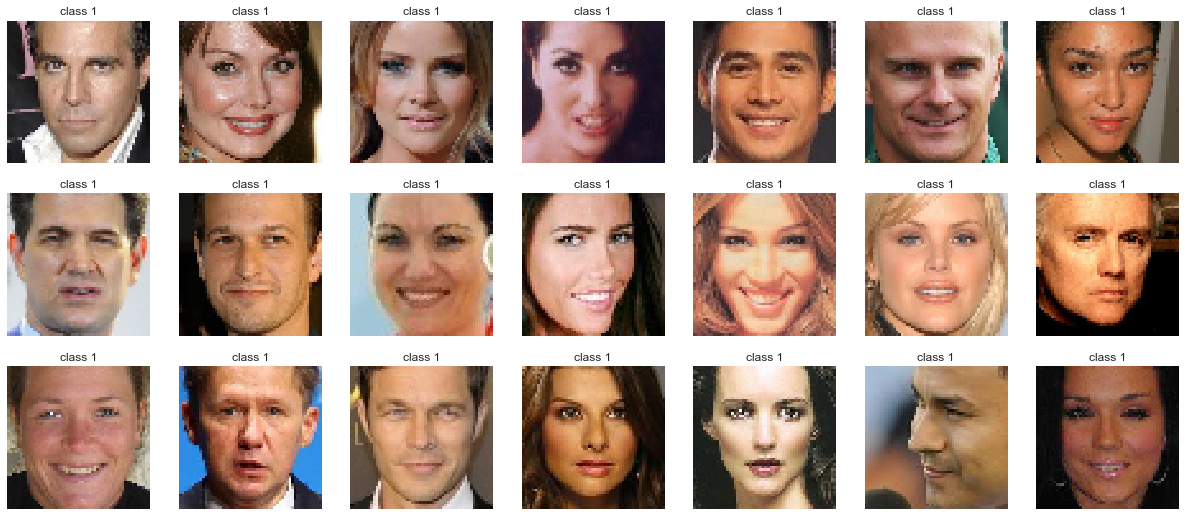

In [4]:
def show_some_images_for_label(label, nrows=3, ncols=7):
    print(" ==> For label :", label)
    index = np.where(train_images_label == label)[0]
    fig = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols*3, nrows*3))
    for i in range(1, ncols*nrows+1):
        plt.subplot(nrows, ncols, i)
        plt.imshow(train_images_data[index[i]].reshape(56, 56, 3).astype(np.uint8))
        plt.xticks([]), plt.yticks([])
        plt.title("class {:.0f}".format(train_images_label[index[i]]))
    plt.show()

for label in [0, 1]:
    show_some_images_for_label(label)

> The challenge was annonced to be a Mustache/Not Mustache classification problem.

> But, after showing some images for both labels, it seems that mustache is not the right issue.

> **The classification problem is more :**
- **Label 0 : face with accessory (like glasses, hat, cap, necklace, mustache, beard, ...)**
- **Label 1 : face without any accessory**

## 1.2 Distribution of Labels in the Training set

In [5]:
train_label_NEG = train_images_label[train_images_label==0]
NB_train_NEG = len(train_label_NEG)

train_label_POS = train_images_label[train_images_label==1]
NB_train_POS = len(train_label_POS)

print("# Neg Label : {:d}  ({:.2f} %)".format(NB_train_NEG, 100*NB_train_NEG/num_train_images))
print("# Pos Label : {:d}  ({:.2f} %)".format(NB_train_POS, 100*NB_train_POS/num_train_images))

# Neg Label : 15250  (13.69 %)
# Pos Label : 96180  (86.31 %)


> The training set is highly unbalanced !  
To be sure that our model will not just learn the probability of distribution (meaning predict Positive label because it's the majority class), we will do an under-sampling to have a more balanced set.

## 1.3 Under Sampling on Training set

In [6]:
from imblearn.under_sampling import RandomUnderSampler

rus = RandomUnderSampler(ratio='auto', random_state=0)
X_under, y_under = rus.fit_sample(train_images_data, train_images_label)

In [7]:
# After under-sampling
train_label_NEG = y_under[y_under==0]
NB_train_NEG = len(train_label_NEG)

train_label_POS = y_under[y_under==1]
NB_train_POS = len(train_label_POS)

print("# Neg Label : {:d}  ({:.2f} %)".format(NB_train_NEG, 100*NB_train_NEG/len(y_under)))
print("# Pos Label : {:d}  ({:.2f} %)".format(NB_train_POS, 100*NB_train_POS/len(y_under)))

# Neg Label : 15250  (50.00 %)
# Pos Label : 15250  (50.00 %)


In [8]:
# Final shape of Training dataset :
print("train data after under-sampling  :", X_under.shape)
print("train label after under-sampling :", y_under.shape)

train data after under-sampling  : (30500, 9408)
train label after under-sampling : (30500,)


> The training set is now clearly balanced !  
Therefore, we have roughly 30'000 images for training our model.

## Alternatives to Under-Sampling :

> 1) Rather than doing under-sampling, we could have done **over-sampling** :

>    - randomly add images of the minority class  
    /!\ if we do this, we must over-sample AFTER the train/test split !!! Otherwise we risk having in the testset some duplicate images that are also in the trainset (thus having some overfitting issue) /!\
>    - data augmentation : add modified images from the minority class

> 2) Keep the dataset unbalanced but **modify the cost function** : add weight for minority class.  
(use the sklearn function : *sklearn.utils.class_weight.compute_class_weight*)



> ==> But as the challenge is compute on my personnal laptop, I decided to do under-sampling to have a smaller dataset and therefore to have a reasonnable computational time rather than using the whole original dataset or more (with over-sampling).

## 1.3 One Hot Encoding of labels

The model I use (describe later) need that our label is not a binary vector but is a one hot encoded labels.

- column 1 = column of label 0
- column 2 = column of label 1

In [9]:
C = 2 # number of classes
Y = y_under.astype(int)
y_under_encoded = np.eye(C)[Y.reshape(-1)]

In [10]:
print("train label after one hot encoding :", y_under_encoded.shape)

train label after one hot encoding : (30500, 2)


## 1.4 Train / Test split

In [11]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_under, y_under_encoded,
                                                    test_size=0.05, shuffle=True, random_state=42)

In [12]:
print("X_train :", X_train.shape)
print("y_train :", y_train.shape)
print("X_test :", X_test.shape)
print("y_test :", y_test.shape)

X_train : (28975, 9408)
y_train : (28975, 2)
X_test : (1525, 9408)
y_test : (1525, 2)


> We extract a small quantity (5%) of our training dataset to check if our model will generalize properly.

## 1.5 Normalize Inputs

In [13]:
X_train = np.divide(X_train, 255., dtype=float)
X_test = np.divide(X_test, 255., dtype=float)

> We divide all the inputs by 255, therefore all the values are between 0 and 1.  
The goal of this normalization is to have a better convergence.

> /!\ Don't forget to also normalize inputs when predict  /!\

# Part 2 : Building the Graph using Tensorflow

> We define the following Convolutionnal Neural Network (based from the DeepLearning course of Stephane Gentric) :
- 4 blocks of :
  - 2 convolutional layers + 1 maxpooling layer
  - The convolutional layers will have 10 filters (3x3) for the first block. And the number of filters will double every block.
- 3 fully connected layers to decrease to 2 outputs.
-  ==> Rem : those layers are defined using a class "Layers" in the file Layers.py
- For these parameters (number of blocks, convolutions, filters) several options were tested and here is the solution that worked best.

> To avoid overfitting, we will use :
- Dropout
- L2 regularization

> To track the performance of our model, we will use the same score as described at the beginning.

> We use Adam Optimizer with an exponentially decay learning rate.

> We use BatchNorm (defined in Layers.py) to have a better convergence. As we use BatchNorm, we don't need to add a bias term (B) in the linear fonction of each neuron.

> We define 3 placeholders :
- x, the inputs
- y_true, the true labels
- ITM, meaning "Is Training Mode", a boolean to set depending on wether we have to use the model in training mode or in prediction mode.

> The hyperparameters to tune are :
- the learning rate (the most important one)
- the dropout used for regularization (the last fully connected layer has no dropout, and the one before last has a small dropout of 0.9)
- the coefficient of L2 regularization

In [14]:
tf.reset_default_graph()

# Parameters to tune
learn_rate = 3e-3
KeepProb_Dropout = 0.8
L2_reg = 0.001

# Parameters of the model
nb_block = 4
nb_conv_per_block = 2
nbfilter_ini = 10


with tf.name_scope('input'):
    dim = 9408  # =(56*56*3)
    x = tf.placeholder(tf.float32, [None, dim], name='x')
    y_true = tf.placeholder(tf.float32, [None, 2], name='y_true')
    ITM = tf.placeholder("bool", name='Is_Training_Mode')

with tf.name_scope('CNN'):
    t = Layers.unflat(x,56,56,3) 
    nbfilter = nbfilter_ini
    for k in range(nb_block):
        for i in range(nb_conv_per_block):
            t = Layers.conv(t, outDim=nbfilter, filterSize=3, stride=1, IsTrainingMode=ITM,
                            name='conv_%d_%d'%(nbfilter,i), KP_dropout=KeepProb_Dropout)
        t = Layers.maxpool(t, poolSize=2, name='pool')
        nbfilter *= 2
    
    t = Layers.flat(t)
    t = Layers.fc(t,256, ITM, 'fc_0', KeepProb_Dropout, act=tf.nn.relu)
    t = Layers.fc(t, 64, ITM, 'fc_1', KP_dropout = 0.9, act=tf.nn.relu)
    z = Layers.fc(t,  2, ITM, 'fc_2', KP_dropout=1.0,   act=tf.identity)


with tf.name_scope('cost_function'):
    cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=z, labels=y_true))
    l2_loss = L2_reg * tf.add_n( [tf.nn.l2_loss(w) for w in tf.get_collection(tf.GraphKeys.WEIGHTS)] )
    cost_func = cross_entropy + l2_loss
    tf.summary.scalar('cost_func', cost_func)

with tf.name_scope('metrics'):
    y_true_vector = tf.cast(tf.argmax(y_true, axis=1), tf.float32)
    y_pred_vector = tf.cast(tf.argmax(z, axis=1), tf.float32)
    with tf.name_scope('score_Challenge'):
        N0 = tf.reduce_sum(tf.cast(tf.equal(y_true_vector, 0), tf.float32))
        N1 = tf.reduce_sum(tf.cast(tf.equal(y_true_vector, 1), tf.float32))
        score_chall = 0.5 * (tf.reduce_sum((1-y_true_vector)*(1-y_pred_vector))/N0 \
                             + tf.reduce_sum(y_true_vector*y_pred_vector)/N1)
        tf.summary.scalar('score_challenge', score_chall)

with tf.name_scope('learning_rate'):
    global_step = tf.Variable(0, trainable=False)
    learning_rate = tf.train.exponential_decay(learn_rate, global_step, decay_steps=200, decay_rate=0.9, staircase=True)
    tf.summary.scalar('learning_rate', learning_rate)

update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
with tf.control_dependencies(update_ops):
    train_step = tf.train.AdamOptimizer(learning_rate).minimize(cost_func, global_step=global_step)

merged = tf.summary.merge_all()


unflat output   Tensor("CNN/Reshape:0", shape=(?, 56, 56, 3), dtype=float32)
conv_10_0 input   Tensor("CNN/Reshape:0", shape=(?, 56, 56, 3), dtype=float32)
conv_10_0 W   (3, 3, 3, 10)
conv_10_1 input   Tensor("CNN/conv_10_0/cond/Merge:0", shape=(?, 56, 56, 10), dtype=float32)
conv_10_1 W   (3, 3, 10, 10)
conv_20_0 input   Tensor("CNN/pool/MaxPool:0", shape=(?, 28, 28, 10), dtype=float32)
conv_20_0 W   (3, 3, 10, 20)
conv_20_1 input   Tensor("CNN/conv_20_0/cond/Merge:0", shape=(?, 28, 28, 20), dtype=float32)
conv_20_1 W   (3, 3, 20, 20)
conv_40_0 input   Tensor("CNN/pool_1/MaxPool:0", shape=(?, 14, 14, 20), dtype=float32)
conv_40_0 W   (3, 3, 20, 40)
conv_40_1 input   Tensor("CNN/conv_40_0/cond/Merge:0", shape=(?, 14, 14, 40), dtype=float32)
conv_40_1 W   (3, 3, 40, 40)
conv_80_0 input   Tensor("CNN/pool_2/MaxPool:0", shape=(?, 7, 7, 40), dtype=float32)
conv_80_0 W   (3, 3, 40, 80)
conv_80_1 input   Tensor("CNN/conv_80_0/cond/Merge:0", shape=(?, 7, 7, 80), dtype=float32)
conv_80_1 W   (

# Part 3 : Train the model

## 3.1 Defining 2 useful functions

- ```random_mini_batches``` : creates a list of random minibatches from (X, Y)
- ```train_model``` : train the CNN over the training set

In [15]:
# Adapted from Coursera - DeepLearning (Course2-Week3-HyperparamTuning_BatchNorm_Frameworks) - by Andrew NG

def random_mini_batches(X, Y, mini_batch_size=64, seed=0):
    """
    Creates a list of random minibatches from (X, Y)
    
    Arguments:
    X -- input data, of shape (number of examples, input size)
    Y -- true "label", of shape (number of examples, 2)
    mini_batch_size - size of the mini-batches, integer
    seed -- to set the randomness
    
    Returns:
    mini_batches -- list of synchronous (mini_batch_X, mini_batch_Y)
    """
    
    m = X.shape[0]     # number of training examples
    mini_batches = []
    np.random.seed(seed)
    
    # Step 1: Shuffle (X, Y)
    permutation = list(np.random.permutation(m))
    shuffled_X = X[permutation, :]
    shuffled_Y = Y[permutation, :]

    # Step 2: Partition (shuffled_X, shuffled_Y). Minus the end case.
    num_complete_minibatches = int(m/mini_batch_size) # number of mini batches of size mini_batch_size in (X, Y)
    for k in range(0, num_complete_minibatches):
        mini_batch_X = shuffled_X[k * mini_batch_size : k * mini_batch_size + mini_batch_size, :]
        mini_batch_Y = shuffled_Y[k * mini_batch_size : k * mini_batch_size + mini_batch_size, :]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    # Handling the end case (last mini-batch < mini_batch_size)
    if m % mini_batch_size != 0:
        mini_batch_X = shuffled_X[num_complete_minibatches * mini_batch_size : m, :]
        mini_batch_Y = shuffled_Y[num_complete_minibatches * mini_batch_size : m, :]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    return mini_batches

In [16]:
def train_model(experiment_name_base, experiment_name, X_train, y_train, X_test, y_test,
                minibatch_size=256, num_epochs_to_run=1, epoch_start=0, it_start=0, print_cost=True):
    
    print ("-------    ", experiment_name, "  -------\n")
    it = it_start
    
    sess = tf.Session()
    saver = tf.train.Saver(max_to_keep=None)  # by default, tf keeps only the 5 last models
    
    if epoch_start == 0:
        sess.run(tf.global_variables_initializer())
    else:
        saver.restore(sess, experiment_name)
    
    writer = tf.summary.FileWriter(experiment_name_base, sess.graph)
    
    score_train_history = []
    score_test_history = []
    
    for epoch in range(num_epochs_to_run):
        
        t0 = time()
        seed = epoch_start + epoch + 1  # at each epoch, set a different seed (to split differently into minibatches)
        minibatches = random_mini_batches(X_train, y_train, minibatch_size, seed)
        
        for minibatch in minibatches:
            
            # Select a minibatch
            (minibatch_X, minibatch_Y) = minibatch
            trainDict = {x:minibatch_X, y_true:minibatch_Y, ITM:True}
            
            # Run a gradient descent step on a minibatch
            sess.run(train_step, feed_dict=trainDict)
            it += 1
            
            # Print informations every 10 iterations
            if print_cost == True and it % 10 == 0:
                cost, sco, lr = sess.run([cost_func, score_chall, learning_rate], feed_dict=trainDict)
                n0 = np.sum(trainDict[y_true][:,0])
                n1 = np.sum(trainDict[y_true][:,1])
                print("it= %6d - rate= %f - cost= %f - score= %f - (#0=%d - #1=%d)" % (it, lr, cost, sco, n0, n1))
                
                # Write (Cost, LearningRate, Score) in tensorboard
                summary_merged = sess.run(merged, feed_dict=trainDict)
                writer.add_summary(summary_merged, it)
        
        # At the end of each epoch, compute score of train & test (/!\ ITM=False here /!\)
        if print_cost == True:
            # Compute Train Score using minibatches
            t = time()
            sco_train = 0
            m = y_train.shape[0]
            for minibatch in minibatches:
                # select a mini-batch
                (minibatch_X, minibatch_Y) = minibatch                
                trainDict = {x:minibatch_X, y_true:minibatch_Y, ITM:False}
                # compute score on current mini-batch and add it to the total
                sco_tmp = sess.run(score_chall, feed_dict=trainDict)
                sco_train += sco_tmp
            sco_train = sco_train / (m/minibatch_size)
            # Keep track of train score
            score_train_history.append(sco_train)
            print ("Train Score: %.6f"%sco_train, "    time=%.3f"%(time()-t))
            
            # Compute Test Score using .eval  (works only for small dataset to evaluate)
            t = time()
            sco_test = score_chall.eval({x: X_test, y_true: y_test, ITM:False}, session=sess)
            # Keep track of test score
            score_test_history.append(sco_test)
            print ("Test Score : %.6f"%sco_test, "    time=%.3f"%(time()-t))
            
            print ("     Execution time after epoch %2d : %.3f (sec)\n" % (epoch_start+epoch+1, time()-t0))
        
        # At the end of each epoch, save the model
        saver.save(sess, experiment_name_base+"_epoch_%d"%(epoch_start+epoch+1))
    
    
    print("last it =", it)
    print("last epoch =", epoch_start+epoch+1)
    print()
    writer.close()
    sess.close()
    
    return it, epoch_start+epoch+1, score_train_history, score_test_history


## 3.2 Run the Training

> To start, we train our CNN on 40 epochs. The model is saved at the end of each epoch.  
The mini-batch size have a real impact on results, so it has to be chosen carefully. 256 works best for my model.

In [17]:
minibatch_size = 256
num_epochs_to_run = 40
epoch_start = 0
it_start = 0

experiment_name_base = "./model_dr%.2f_mbs%d_block%d_conv%d_filter%d_lr%.4f_L2-%.3f.ckpt" % \
                    (KeepProb_Dropout, minibatch_size, nb_block, nb_conv_per_block, nbfilter_ini, learn_rate, L2_reg)
experiment_name = experiment_name_base

#  TRAIN THE MODEL
last_it, last_epoch, score_train_history_40, score_test_history_40 = train_model(experiment_name_base,
                                                                                 experiment_name,
                                                                                 X_train, y_train,
                                                                                 X_test, y_test,
                                                                                 minibatch_size,
                                                                                 num_epochs_to_run,
                                                                                 epoch_start,
                                                                                 it_start,
                                                                                 print_cost = True)

np.savetxt("score_train_history_40.txt", score_train_history_40)
np.savetxt("score_test_history_40.txt", score_test_history_40)

-------     ./model_dr0.80_mbs256_block4_conv2_filter10_lr0.0030_L2-0.001.ckpt   -------

it=     10 - rate= 0.003000 - cost= 0.915559 - score= 0.642097 - (#0=122 - #1=134)
it=     20 - rate= 0.003000 - cost= 0.865833 - score= 0.711631 - (#0=121 - #1=135)
it=     30 - rate= 0.003000 - cost= 0.822692 - score= 0.731838 - (#0=142 - #1=114)
it=     40 - rate= 0.003000 - cost= 0.724368 - score= 0.770588 - (#0=120 - #1=136)
it=     50 - rate= 0.003000 - cost= 0.694252 - score= 0.762424 - (#0=133 - #1=123)
it=     60 - rate= 0.003000 - cost= 0.625363 - score= 0.842382 - (#0=125 - #1=131)
it=     70 - rate= 0.003000 - cost= 0.635382 - score= 0.815647 - (#0=118 - #1=138)
it=     80 - rate= 0.003000 - cost= 0.548579 - score= 0.863836 - (#0=123 - #1=133)
it=     90 - rate= 0.003000 - cost= 0.515948 - score= 0.855494 - (#0=126 - #1=130)
it=    100 - rate= 0.003000 - cost= 0.481321 - score= 0.876075 - (#0=118 - #1=138)
it=    110 - rate= 0.003000 - cost= 0.496425 - score= 0.837826 - (#0=133 - #1=12

it=    790 - rate= 0.002187 - cost= 0.331788 - score= 0.895387 - (#0=137 - #1=119)
Train Score: 0.925197     time=101.909
Test Score : 0.905951     time=6.631
     Execution time after epoch  7 : 490.288 (sec)

INFO:tensorflow:./model_dr0.80_mbs256_block4_conv2_filter10_lr0.0030_L2-0.001.ckpt_epoch_7 is not in all_model_checkpoint_paths. Manually adding it.
it=    800 - rate= 0.001968 - cost= 0.256249 - score= 0.914662 - (#0=121 - #1=135)
it=    810 - rate= 0.001968 - cost= 0.247866 - score= 0.909113 - (#0=140 - #1=116)
it=    820 - rate= 0.001968 - cost= 0.249152 - score= 0.905832 - (#0=131 - #1=125)
it=    830 - rate= 0.001968 - cost= 0.250351 - score= 0.913466 - (#0=131 - #1=125)
it=    840 - rate= 0.001968 - cost= 0.246353 - score= 0.914706 - (#0=120 - #1=136)
it=    850 - rate= 0.001968 - cost= 0.257741 - score= 0.914408 - (#0=130 - #1=126)
it=    860 - rate= 0.001968 - cost= 0.265960 - score= 0.919233 - (#0=124 - #1=132)
it=    870 - rate= 0.001968 - cost= 0.230215 - score= 0.925

it=   1550 - rate= 0.001435 - cost= 0.275622 - score= 0.925746 - (#0=127 - #1=129)
it=   1560 - rate= 0.001435 - cost= 0.261375 - score= 0.929688 - (#0=128 - #1=128)
it=   1570 - rate= 0.001435 - cost= 0.223215 - score= 0.923143 - (#0=119 - #1=137)
it=   1580 - rate= 0.001435 - cost= 0.235404 - score= 0.921641 - (#0=135 - #1=121)
it=   1590 - rate= 0.001435 - cost= 0.218444 - score= 0.925344 - (#0=135 - #1=121)
Train Score: 0.909904     time=104.736
Test Score : 0.894521     time=6.908
     Execution time after epoch 14 : 481.104 (sec)

INFO:tensorflow:./model_dr0.80_mbs256_block4_conv2_filter10_lr0.0030_L2-0.001.ckpt_epoch_14 is not in all_model_checkpoint_paths. Manually adding it.
it=   1600 - rate= 0.001291 - cost= 0.236716 - score= 0.917969 - (#0=128 - #1=128)
it=   1610 - rate= 0.001291 - cost= 0.192181 - score= 0.934559 - (#0=120 - #1=136)
it=   1620 - rate= 0.001291 - cost= 0.291171 - score= 0.898492 - (#0=127 - #1=129)
it=   1630 - rate= 0.001291 - cost= 0.242194 - score= 0.91

it=   2310 - rate= 0.000941 - cost= 0.196600 - score= 0.949023 - (#0=130 - #1=126)
it=   2320 - rate= 0.000941 - cost= 0.237687 - score= 0.935006 - (#0=117 - #1=139)
it=   2330 - rate= 0.000941 - cost= 0.214114 - score= 0.918238 - (#0=127 - #1=129)
it=   2340 - rate= 0.000941 - cost= 0.229142 - score= 0.922565 - (#0=125 - #1=131)
it=   2350 - rate= 0.000941 - cost= 0.162328 - score= 0.960550 - (#0=131 - #1=125)
it=   2360 - rate= 0.000941 - cost= 0.206679 - score= 0.929561 - (#0=129 - #1=127)
it=   2370 - rate= 0.000941 - cost= 0.192994 - score= 0.929688 - (#0=128 - #1=128)
it=   2380 - rate= 0.000941 - cost= 0.192832 - score= 0.948733 - (#0=131 - #1=125)
it=   2390 - rate= 0.000941 - cost= 0.216166 - score= 0.925689 - (#0=137 - #1=119)
Train Score: 0.942555     time=100.872
Test Score : 0.914784     time=6.821
     Execution time after epoch 21 : 480.420 (sec)

INFO:tensorflow:./model_dr0.80_mbs256_block4_conv2_filter10_lr0.0030_L2-0.001.ckpt_epoch_21 is not in all_model_checkpoint_pa

it=   3080 - rate= 0.000618 - cost= 0.191583 - score= 0.949282 - (#0=131 - #1=125)
it=   3090 - rate= 0.000618 - cost= 0.195024 - score= 0.945098 - (#0=136 - #1=120)
it=   3100 - rate= 0.000618 - cost= 0.208049 - score= 0.925831 - (#0=124 - #1=132)
it=   3110 - rate= 0.000618 - cost= 0.165721 - score= 0.949291 - (#0=124 - #1=132)
it=   3120 - rate= 0.000618 - cost= 0.213102 - score= 0.926565 - (#0=125 - #1=131)
it=   3130 - rate= 0.000618 - cost= 0.216937 - score= 0.947249 - (#0=119 - #1=137)
it=   3140 - rate= 0.000618 - cost= 0.193096 - score= 0.948775 - (#0=136 - #1=120)
it=   3150 - rate= 0.000618 - cost= 0.221062 - score= 0.924697 - (#0=111 - #1=145)
it=   3160 - rate= 0.000618 - cost= 0.175959 - score= 0.957600 - (#0=124 - #1=132)
it=   3170 - rate= 0.000618 - cost= 0.160971 - score= 0.945421 - (#0=126 - #1=130)
it=   3180 - rate= 0.000618 - cost= 0.210384 - score= 0.949709 - (#0=121 - #1=135)
it=   3190 - rate= 0.000618 - cost= 0.187858 - score= 0.938235 - (#0=120 - #1=136)
Trai

it=   3870 - rate= 0.000405 - cost= 0.158561 - score= 0.953099 - (#0=115 - #1=141)
Train Score: 0.954694     time=99.297
Test Score : 0.914540     time=6.779
     Execution time after epoch 34 : 474.563 (sec)

INFO:tensorflow:./model_dr0.80_mbs256_block4_conv2_filter10_lr0.0030_L2-0.001.ckpt_epoch_34 is not in all_model_checkpoint_paths. Manually adding it.
it=   3880 - rate= 0.000405 - cost= 0.205070 - score= 0.924388 - (#0=142 - #1=114)
it=   3890 - rate= 0.000405 - cost= 0.176516 - score= 0.936706 - (#0=132 - #1=124)
it=   3900 - rate= 0.000405 - cost= 0.141270 - score= 0.964332 - (#0=133 - #1=123)
it=   3910 - rate= 0.000405 - cost= 0.144871 - score= 0.964844 - (#0=128 - #1=128)
it=   3920 - rate= 0.000405 - cost= 0.165602 - score= 0.949634 - (#0=126 - #1=130)
it=   3930 - rate= 0.000405 - cost= 0.184000 - score= 0.945503 - (#0=124 - #1=132)
it=   3940 - rate= 0.000405 - cost= 0.230215 - score= 0.912010 - (#0=120 - #1=136)
it=   3950 - rate= 0.000405 - cost= 0.160667 - score= 0.956

> Let's train a bit longer our CNN to see if we can have less bias.

In [18]:
minibatch_size = 256
num_epochs_to_run = 15
epoch_start = 40
it_start = 4560

experiment_name = "./model_dr0.80_mbs256_block4_conv2_filter10_lr0.0030_L2-0.001.ckpt_epoch_40"

#  TRAIN THE MODEL
last_it, last_epoch, score_train_history_40_55, score_test_history_40_55 = train_model(experiment_name_base,
                                                                                       experiment_name,
                                                                                       X_train, y_train,
                                                                                       X_test, y_test,
                                                                                       minibatch_size,
                                                                                       num_epochs_to_run,
                                                                                       epoch_start,
                                                                                       it_start,
                                                                                       print_cost = True)

np.savetxt("score_train_history_40_55.txt", score_train_history_40_55)
np.savetxt("score_test_history_40_55.txt", score_test_history_40_55)

-------     ./model_dr0.80_mbs256_block4_conv2_filter10_lr0.0030_L2-0.001.ckpt_epoch_40   -------

INFO:tensorflow:Restoring parameters from ./model_dr0.80_mbs256_block4_conv2_filter10_lr0.0030_L2-0.001.ckpt_epoch_40
it=   4570 - rate= 0.000295 - cost= 0.120780 - score= 0.969085 - (#0=121 - #1=135)
it=   4580 - rate= 0.000295 - cost= 0.133106 - score= 0.968620 - (#0=130 - #1=126)
it=   4590 - rate= 0.000295 - cost= 0.149258 - score= 0.957808 - (#0=114 - #1=142)
it=   4600 - rate= 0.000266 - cost= 0.183654 - score= 0.956550 - (#0=131 - #1=125)
it=   4610 - rate= 0.000266 - cost= 0.157622 - score= 0.938294 - (#0=137 - #1=119)
it=   4620 - rate= 0.000266 - cost= 0.149972 - score= 0.957099 - (#0=131 - #1=125)
it=   4630 - rate= 0.000266 - cost= 0.136840 - score= 0.945015 - (#0=132 - #1=124)
it=   4640 - rate= 0.000266 - cost= 0.155476 - score= 0.941575 - (#0=130 - #1=126)
it=   4650 - rate= 0.000266 - cost= 0.137831 - score= 0.964733 - (#0=131 - #1=125)
it=   4660 - rate= 0.000266 - cost= 

it=   5340 - rate= 0.000194 - cost= 0.148394 - score= 0.957204 - (#0=126 - #1=130)
it=   5350 - rate= 0.000194 - cost= 0.174098 - score= 0.938016 - (#0=133 - #1=123)
Train Score: 0.964402     time=113.477
Test Score : 0.915289     time=8.876
     Execution time after epoch 47 : 517.179 (sec)

INFO:tensorflow:./model_dr0.80_mbs256_block4_conv2_filter10_lr0.0030_L2-0.001.ckpt_epoch_47 is not in all_model_checkpoint_paths. Manually adding it.
it=   5360 - rate= 0.000194 - cost= 0.119198 - score= 0.967491 - (#0=137 - #1=119)
it=   5370 - rate= 0.000194 - cost= 0.107072 - score= 0.973379 - (#0=123 - #1=133)
it=   5380 - rate= 0.000194 - cost= 0.135453 - score= 0.962106 - (#0=121 - #1=135)
it=   5390 - rate= 0.000194 - cost= 0.167457 - score= 0.953282 - (#0=125 - #1=131)
it=   5400 - rate= 0.000174 - cost= 0.152434 - score= 0.957204 - (#0=126 - #1=130)
it=   5410 - rate= 0.000174 - cost= 0.165612 - score= 0.953389 - (#0=122 - #1=134)
it=   5420 - rate= 0.000174 - cost= 0.169562 - score= 0.96

it=   6100 - rate= 0.000127 - cost= 0.126700 - score= 0.957282 - (#0=125 - #1=131)
it=   6110 - rate= 0.000127 - cost= 0.148528 - score= 0.960878 - (#0=133 - #1=123)
it=   6120 - rate= 0.000127 - cost= 0.141180 - score= 0.968748 - (#0=129 - #1=127)
it=   6130 - rate= 0.000127 - cost= 0.129425 - score= 0.969147 - (#0=119 - #1=137)
it=   6140 - rate= 0.000127 - cost= 0.126436 - score= 0.961416 - (#0=126 - #1=130)
it=   6150 - rate= 0.000127 - cost= 0.128176 - score= 0.957114 - (#0=113 - #1=143)
Train Score: 0.972869     time=109.899
Test Score : 0.914860     time=7.214
     Execution time after epoch 54 : 515.055 (sec)

INFO:tensorflow:./model_dr0.80_mbs256_block4_conv2_filter10_lr0.0030_L2-0.001.ckpt_epoch_54 is not in all_model_checkpoint_paths. Manually adding it.
it=   6160 - rate= 0.000127 - cost= 0.110289 - score= 0.974024 - (#0=118 - #1=138)
it=   6170 - rate= 0.000127 - cost= 0.143508 - score= 0.955257 - (#0=113 - #1=143)
it=   6180 - rate= 0.000127 - cost= 0.121399 - score= 0.96

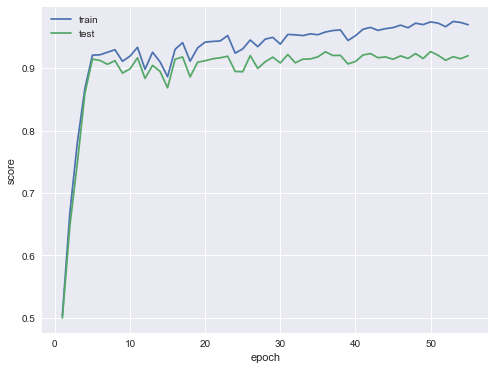

In [19]:
# Plot Score on Train & Test Set

# Concatenate 2 history files
score_train_history = np.concatenate((np.loadtxt("score_train_history_40.txt"),
                                      np.loadtxt("score_train_history_40_55.txt")))
score_test_history = np.concatenate((np.loadtxt("score_test_history_40.txt"),
                                     np.loadtxt("score_test_history_40_55.txt")))

fig = plt.figure(figsize=(8, 6))
x = np.arange(1, len(score_train_history)+1)
plt.plot(x, score_train_history, label="train")
plt.plot(x, score_test_history, label="test")
plt.xlabel("epoch")
plt.ylabel("score")
plt.legend()
plt.show()

In [20]:
# Print Max Score by Set
print('Max Score on Train : {:.6f}  (epoch #{})'.format(score_train_history.max(), score_train_history.argmax()+1))
print('Max Score on Test  : {:.6f}  (epoch #{})'.format(score_test_history.max(), score_test_history.argmax()+1))

Max Score on Train : 0.974508  (epoch #53)
Max Score on Test  : 0.926322  (epoch #50)


### Conclusion:

> We have reduce the Bias (the score on Train have increased and is close to 97%).

> But it seems that we have some Overfitting (very good performance on train but not as good on test).
To avoid overfitting, we could think of those 2 options :
- use more data (not an option here because we lack of computational time...)
- use more regularization (dropout + L2)

</br>

> To have a better idea of the overall performance, let's use our 3 best models on the whole original training dataset (the one that is not sub-sampled) : 111'430 images, 28'975 of whom served for the training.

> The 3 best models are those which have the best Test Score. The table below shows the score, sorted by Test Score.

In [21]:
# DataFrame of Train & Test Score
df_score = pd.DataFrame(data    = np.vstack((score_train_history, score_test_history)).T,
                        index   = np.arange(1, len(score_train_history)+1),
                        columns = ['Train','Test'])

# Sort by Test Score
df_score.sort_values('Test', ascending=False, inplace=True)
df_score.head()

,Train,Test
50,0.973781,0.926322
36,0.957624,0.926001
42,0.965015,0.923128
48,0.971759,0.923128
31,0.953721,0.921569


### Conclusion:
> The 3 best models are :
- model after 50 epoch
- model after 36 epoch
- model after 42 epoch.

# Part 4 : Compute Score on a larger number of images

## 4.1 Define 2 useful functions

In [22]:
def mini_batches_score_allDB(X, Y, mini_batch_size=256):
    
    m = X.shape[0]          # number of training examples
    mini_batches = []

    # Here we don't need to shuffle the data before splitting into mini-batches!
    
    # Partition (X, Y). Minus the end case.
    num_complete_minibatches = int(m/mini_batch_size)
    for k in range(0, num_complete_minibatches):
        mini_batch_X = X[k * mini_batch_size : k * mini_batch_size + mini_batch_size, :]
        mini_batch_Y = Y[k * mini_batch_size : k * mini_batch_size + mini_batch_size, :]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    # Handling the end case (last mini-batch < mini_batch_size)
    if m % mini_batch_size != 0:
        mini_batch_X = X[num_complete_minibatches * mini_batch_size : m, :]
        mini_batch_Y = Y[num_complete_minibatches * mini_batch_size : m, :]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    return mini_batches

In [23]:
def compute_score_all_trainDB(model_to_restore, train_images_data, train_images_label, mbs=256, print_time=True):
    
    with tf.Session() as sess:
        t0 = time()
        
        # Restore the model
        saver = tf.train.Saver()
        saver.restore(sess, model_to_restore)
        
        # One hot encoding of the binary vector of labels
        train_images_label_encoded = np.eye(2)[train_images_label.astype(int).reshape(-1)]
        
        # Split into mini-batches
        minibatches = mini_batches_score_allDB(train_images_data, train_images_label_encoded, mini_batch_size=mbs)
        sco_train = 0
        
        for i, minibatch in enumerate(minibatches):
            # Select a mini-batch
            (minibatch_X, minibatch_Y) = minibatch
            
            # Normalize Inputs
            minibatch_X_norm = np.divide(minibatch_X, 255., dtype=float)
            
            # Compute score on current mini-batch and add it to total
            trainDict = {x:minibatch_X_norm, y_true:minibatch_Y, ITM:False}
            sco_tmp = sess.run(score_chall, feed_dict=trainDict)
            sco_train += sco_tmp
            
            if print_time == True and i % 100 == 0:
                print("iteration %d - Execution time from start: %.2f (sec)"%(i, time()-t0))
        
        m = train_images_label_encoded.shape[0]
        sco_train = sco_train / (m/mbs)
        
        print("Execution Time : %.3f (sec)" % (time()-t0))
        print("  ==> Score = %.6f" % sco_train)
        
        return sco_train

## 4.2 Compute Score on all the Train database to have a better idea of the performance of ours 3 best models : epoch50, epoch36 & epoch42

In [24]:
# Model at the end of epoch 50
model_to_restore = "./model_dr0.80_mbs256_block4_conv2_filter10_lr0.0030_L2-0.001.ckpt_epoch_50"

score_allTrainDB_ep50 = compute_score_all_trainDB(model_to_restore, train_images_data, train_images_label,
                                                  mbs=256, print_time=True)


INFO:tensorflow:Restoring parameters from ./model_dr0.80_mbs256_block4_conv2_filter10_lr0.0030_L2-0.001.ckpt_epoch_50
iteration 0 - Execution time from start: 1.86 (sec)
iteration 100 - Execution time from start: 107.71 (sec)
iteration 200 - Execution time from start: 214.05 (sec)
iteration 300 - Execution time from start: 315.14 (sec)
iteration 400 - Execution time from start: 425.25 (sec)
Execution Time : 464.022
  ==> Score = 0.954578


In [25]:
# Model at the end of epoch 36
model_to_restore = "./model_dr0.80_mbs256_block4_conv2_filter10_lr0.0030_L2-0.001.ckpt_epoch_36"

score_allTrainDB_ep36 = compute_score_all_trainDB(model_to_restore, train_images_data, train_images_label,
                                                  mbs=256, print_time=True)


INFO:tensorflow:Restoring parameters from ./model_dr0.80_mbs256_block4_conv2_filter10_lr0.0030_L2-0.001.ckpt_epoch_36
iteration 0 - Execution time from start: 2.12 (sec)
iteration 100 - Execution time from start: 105.97 (sec)
iteration 200 - Execution time from start: 211.90 (sec)
iteration 300 - Execution time from start: 317.48 (sec)
iteration 400 - Execution time from start: 422.35 (sec)
Execution Time : 458.373
  ==> Score = 0.942712


In [26]:
# Model at the end of epoch 42
model_to_restore = "./model_dr0.80_mbs256_block4_conv2_filter10_lr0.0030_L2-0.001.ckpt_epoch_42"

score_allTrainDB_ep42 = compute_score_all_trainDB(model_to_restore, train_images_data, train_images_label,
                                                  mbs=256, print_time=True)


INFO:tensorflow:Restoring parameters from ./model_dr0.80_mbs256_block4_conv2_filter10_lr0.0030_L2-0.001.ckpt_epoch_42
iteration 0 - Execution time from start: 2.05 (sec)
iteration 100 - Execution time from start: 103.65 (sec)
iteration 200 - Execution time from start: 204.30 (sec)
iteration 300 - Execution time from start: 305.33 (sec)
iteration 400 - Execution time from start: 407.98 (sec)
Execution Time : 443.564
  ==> Score = 0.948400


> The performances computed on the whole original training dataset are good.  
We can say that our model is able to generalize to new data (here only 1/3 of the original whole trainDB actually served for the training)

# Part 5 :  Compute Predictions

## 5.1 Define 2 useful functions

In [27]:
def mini_batches_pred(X, mini_batch_size=64):
    
    m = X.shape[0]   # number of training examples
    mini_batches = []

    # Partition X. Minus the end case.
    num_complete_minibatches = int(m/mini_batch_size)
    for k in range(0, num_complete_minibatches):
        mini_batch_X = X[k * mini_batch_size : k * mini_batch_size + mini_batch_size, :]
        mini_batches.append(mini_batch_X)
    
    # Handling the end case (last mini-batch < mini_batch_size)
    if m % mini_batch_size != 0:
        mini_batch_X = X[num_complete_minibatches * mini_batch_size : m, :]
        mini_batches.append(mini_batch_X)
    
    return mini_batches


In [28]:
def compute_pred(model_to_restore, images_data, mbs=256, print_time=True):
    
    with tf.Session() as sess:
        t0 = time()
        
        # Restore model
        saver = tf.train.Saver()
        saver.restore(sess, model_to_restore)
        
        # Normalize inputs
        images_data_norm = np.divide(images_data, 255., dtype=float)
        
        # Split into mini-batches
        all_pred = np.array([])  # initialize
        minibatches = mini_batches_pred(images_data_norm, mini_batch_size=mbs)
        
        # Compute Pred for each mini-batch
        for i, minibatch_X in enumerate(minibatches):
            # compute prediction
            minibatch_pred = sess.run(y_pred_vector, feed_dict={x:minibatch_X, ITM:False})
            # append minibatch_pred to the final prediction array
            all_pred = np.append(all_pred, minibatch_pred, axis=0)
            
            if print_time == True and i % 100 == 0:
                print("iteration %d - Execution time from start: %.2f (sec)"%(i, time()-t0))
        
        print("Execution Time : %.3f" % (time()-t0))
        print("  ==> Final pred shape:", all_pred.shape)
        
        return  all_pred
        

## 5.2 Make Predictions with ours 3 best models and save them into a .txt file

In [29]:
# Model at the end of epoch 50
model_to_restore = "./model_dr0.80_mbs256_block4_conv2_filter10_lr0.0030_L2-0.001.ckpt_epoch_50"

#pred_val_50 = compute_pred(model_to_restore, val_images_data, mbs=256)  # on Validation set
pred_test_50 = compute_pred(model_to_restore, test_images_data, mbs=256)  # on Test set

np.savetxt("test_pred_50.txt", pred_test_50, fmt="%d")

INFO:tensorflow:Restoring parameters from ./model_dr0.80_mbs256_block4_conv2_filter10_lr0.0030_L2-0.001.ckpt_epoch_50
iteration 0 - Execution time from start: 40.29 (sec)
iteration 100 - Execution time from start: 151.70 (sec)
iteration 200 - Execution time from start: 261.99 (sec)
iteration 300 - Execution time from start: 371.43 (sec)
Execution Time : 388.121
  ==> Final pred shape: (81039,)


In [30]:
# Model at the end of epoch 36
model_to_restore = "./model_dr0.80_mbs256_block4_conv2_filter10_lr0.0030_L2-0.001.ckpt_epoch_36"

#pred_val_36 = compute_pred(model_to_restore, val_images_data, mbs=256)  # on Validation set
pred_test_36 = compute_pred(model_to_restore, test_images_data, mbs=256)  # on Test set

np.savetxt("test_pred_36.txt", pred_test_36, fmt="%d")

INFO:tensorflow:Restoring parameters from ./model_dr0.80_mbs256_block4_conv2_filter10_lr0.0030_L2-0.001.ckpt_epoch_36
iteration 0 - Execution time from start: 33.32 (sec)
iteration 100 - Execution time from start: 147.25 (sec)
iteration 200 - Execution time from start: 257.74 (sec)
iteration 300 - Execution time from start: 369.38 (sec)
Execution Time : 386.909
  ==> Final pred shape: (81039,)


In [31]:
# Model at the end of epoch 42
model_to_restore = "./model_dr0.80_mbs256_block4_conv2_filter10_lr0.0030_L2-0.001.ckpt_epoch_42"

#pred_val_42 = compute_pred(model_to_restore, val_images_data, mbs=256)  # on Validation set
pred_test_42 = compute_pred(model_to_restore, test_images_data, mbs=256)  # on Test set

np.savetxt("test_pred_42.txt", pred_test_42, fmt="%d")

INFO:tensorflow:Restoring parameters from ./model_dr0.80_mbs256_block4_conv2_filter10_lr0.0030_L2-0.001.ckpt_epoch_42
iteration 0 - Execution time from start: 25.43 (sec)
iteration 100 - Execution time from start: 134.90 (sec)
iteration 200 - Execution time from start: 246.45 (sec)
iteration 300 - Execution time from start: 359.75 (sec)
Execution Time : 376.262
  ==> Final pred shape: (81039,)


<br>

# ==> Results obtained :

> The final rank has been calculated based on the Test dataset (81'039 images).

> For this dataset, I got a score of 0.933383578223, which ranked me 7th on 57 students.

## Other ideas to increase the performance :

> - Try different models (same architecture but with different nb of blocks, nb of convolutions per block, nb of filters, ...   or different architectures)
- Keep the best models and combine their results using Voting Classifier :
  - Hard voting : vote for the majority predicted class
  - Soft voting : instead of the predictions, use the output probabilities of belonging to classes and average them.

<br>

> - Ensemble Learning :
  - combine the output (probabilities) of several CNN with : ExtraTrees, or Logistic Regression, or LinearSVM, or a small Neural Network, ...

## Other idea to try:

> Use the images in Grayscale instead of RGB (because perhaps Accessory/No Accessory classification doesn't need the color information).

> The learning will be a lot faster :
  - the quantity of input is divided by 3 for each image,
  - so we have a lot less parameters to learn.